In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython
%reload_ext Cython

In [2]:
import sys
sys.path.append('..')
import warnings
def warn(message = None, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn

In [3]:
import pandas as pd
import numpy as np
import time
import datetime as dt
from pathlib import Path
import time
#custom
from data_functions import make_date_to_MYR
from diabetes_onset import( process_canary,
get_tc, in_canary, diabet_onset, not_first_month_diabetes, 
                           match_data_per_month, 
                           filter_first_month_diabetes,
                           matched_population, 
                           propensity_func,
                           nearest_neighbor_func, 
                           random_matching_func, agglomerative )

from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.random.seed(seed = 0)

In [4]:
%%time
pp_str = 'Pre_Matching_DATA/'

treated2 = pd.read_pickle(pp_str+'treated2Past.p')
controls = pd.read_pickle(pp_str+'controlsPast.p')
pmpm =pd.read_pickle(pp_str+'pmpm.p')

CPU times: user 7.44 s, sys: 17.9 s, total: 25.4 s
Wall time: 1min 18s


In [5]:
random_controls = pd.read_pickle('tempHybridSelectionMoreData/random.p')

In [6]:
pmpm.head(2)

PERS_ID     MYR MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT MEDICAID_LOB  ALLOW_ER  ALLOW_IP  CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS  CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR  CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER  CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  \
0      -3  201908        M              119          0   Commercial       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          0                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              0.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0   
1      -3  201909        M              119          0   Commercial       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          0                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              0.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0   

   CC_OSTEOPOROSIS  CC_PERIPHERAL  CC_PERSONALITY  CC_PRESSURE  CC_PROSTATE_CANCER  CC_PTSD  CC_SCHIZOPHRENIA  CC_SCHIZOPHRENIA_OTHER  CC_SPINAL_CORD  CC_SPINA_BIFIDA  CC_STROKE  CC_TOBACCO  CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR  LOB  PREGNANCY  IP_BIN  ER_BIN  ACUTE  IP_C  ER_C  ACUTE_C  IP_BIN6  ER_BIN6  ACUTE6  IP_BIN2  ER_BIN2  ACUTE2  
0              0.0            0.0             0.0          0.0                 0.0      0.0               0.0                     0.0             0.0              0.0        0.0         0.0                 0.0               0.0    1        0.0       0       0      0     0     0        0      0.0      0.0     0.0      0.0      0.0     0.0  
1              0.0            0.0             0.0          0.0                 0.0      0.0               0.0                     0.0             0.0              0.0        0.0         0.0                 0.0               0.0    1        0.0       0       0      0     0     0        0      0.0      0.0     0.0      0.0      0

#### Hierarchical Clustering
> Divide the Treated population in two clusters and study the <strong>Onset of Diabetes Onset</strong> separately in each of the clusters

In [7]:
unique = len(treated2.PERS_ID.unique())
clusters = int(unique**(1/2))
unique

In [8]:
clusters = 10
sec_id = ""

In [9]:
columns_to_match_hier = ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT']

#columns_to_match_hier = ['AGE_AT_MIDMONTH',   'CC_TOBACCO',  'CC_OBESITY',
                  # 'CC_HYPERTENSION', 'CC_DX_CNT']


treated0, treated1, model, link_matr,  clustermapdat, treated22 = agglomerative(treated2.copy(),
                                                                                columns_to_match_hier ,
                                                                                n_clusters = clusters,
                                                                               filterpast = True)

In [10]:
treated22

PERS_ID     MYR  MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT MEDICAID_LOB  ALLOW_ER  ALLOW_IP  CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS  CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR  CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER  CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  \
0     2602482  201908         0               81 -23.025851   Commercial       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  1.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                1          1                    0.0          0.0              0.0          0.0                1.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              0.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0   
1     2603072  202001         0               82   4.615121     Medicare       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  1.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          3                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                1.0              1.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0   
2     2606370  202010         0               82   3.135494     Medicare       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  1.0           0.0        0.0            1.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            1.0                      0.0                0.0          0.0                0          5                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              0.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         1.0   
3 

In [11]:
treated3 = pd.merge(treated2, treated22[['PERS_ID', 'Group']],  on = 'PERS_ID')

#### Visualization of the clusters created in the previous step with a clustermap

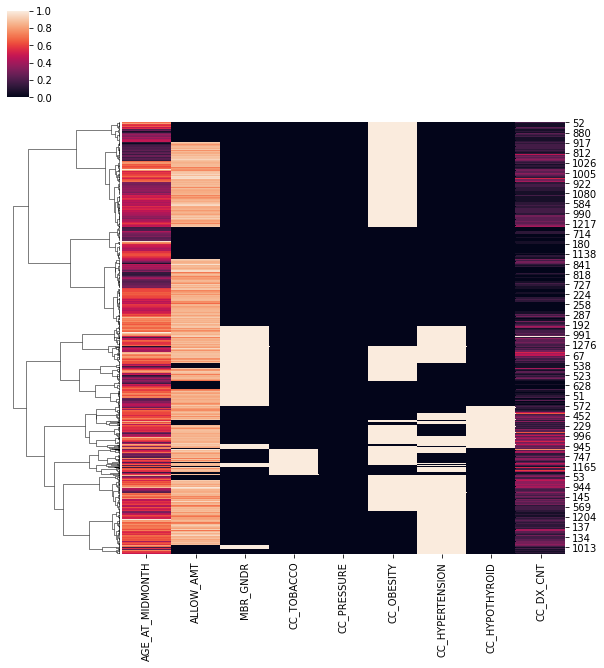

In [12]:
g = sns.clustermap(clustermapdat, method = 'ward', standard_scale=1, row_linkage = link_matr, col_cluster = False)

#### For each of the two clusters formed from the Treated patients form a matched population from the controls.
<div style="background:Aliceblue"> We use hier matching as our matching function</div>

In [13]:
#cols = list(col for col in treated2.columns if col not in ['PERS_ID', 'MYR'])
#columns_to_match = cols
columns_to_match =  ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6','LOB']

%%time

#columns_to_match = columns_to_match + ['IP_BIN2', 'ER_BIN2']
#hier_cols = ['IP_BIN2', 'ER_BIN2', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6']
match_on = ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'ACUTE2']
hier_cols = ['IP_BIN6', 'ER_BIN6']
hier_range = [1,1]
exact_match_dict = {'IP_BIN6':[0,1,2], 'ER_BIN6':[0,1,2], 'LOB':None}
nnr_func_args = {'match_on':match_on, 'hier_cols':hier_cols,
                        'hier_range':hier_range, 'neighbors_per_treated': 5,
                 'onset': "CC_DIABETES", "onset_val" : 0, 'exact_match': True, 'exact_match_dict': exact_match_dict}


matched1, matched_data1 = matched_population(treated3.copy(), 
                                           controls.copy(),
                                           nearest_neighbor_func, 
                                           nnr_func_args)

### Save data

In [14]:
pp = './tempNNhierAgglotheory{}Clusters{}/'.format(clusters, sec_id)
Path(pp).mkdir(exist_ok = True)
p1 = 'tempNNhierAgglotheory{}Clusters{}/'.format(clusters, sec_id)
#matched_data1.to_pickle(p+'match1.p')
#treated1.to_pickle(p+'treated1.p')

p = './tempNNhierAgglotheory/'


In [15]:
with open(p+'matchesPast.p', 'rb') as handle:
    matched1 = pickle.load(handle)


In [16]:
pmpm2 = pmpm
try:
    pmpm2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
except:
    pass

In [17]:
from utils import statistics_first_month, p_val, stat_matrices 

### List containing all numerical columns

In [18]:
all_columns = list(set(col for col in pmpm.columns)-set(['PERS_ID', 'MYR','MEDICAID_LOB']))

In [19]:
treat_test = treated22.copy()
treat_test.set_index('PERS_ID', inplace = True)
unique_groups = sorted(list(treat_test.Group.unique()))
len(unique_groups)

In [20]:
controls22 = controls.copy()
controls22 = controls22.set_index('PERS_ID', drop = False)

### Initialize groups

In [21]:
control_groups = {}
groups_id = {}
for group in unique_groups:
    control_groups[group] = pd.DataFrame()
    groups_id[group] = []

### Get For each group treated ids and matched controls

In [22]:
#controls_all = pd.DataFrame()

In [23]:
%%time
counter = 0
for (key, month), val in matched1.items():
    if len(val) < 5:
        counter += 1
        continue
    gt = treat_test.loc[key].Group
    val['RD'] = val.MYR
    #print(gt)
    #filt1 = controls
    first = controls22.loc[val['PERS_ID']].reset_index(drop = True)
    #new_dat = pd.merge(controls, val[['PERS_ID','RD']],  on = 'PERS_ID')
    
    new_dat = pd.merge(first, val[['PERS_ID','RD']],  on = 'PERS_ID',)
    new_dat['PERS_ID2'] = new_dat.PERS_ID
    new_dat['PERS_ID'] = new_dat['PERS_ID']+str(counter)  
    new_dat['TR-MATCH'] = key
    filt = new_dat.MYR >= new_dat.RD
    new_dat2 = new_dat[filt].reset_index(drop = True)
    
    #control_groups[group] = new_dat2
    control_groups[gt] = pd.concat((control_groups[gt], new_dat2), ignore_index = True)
    #controls_all = pd.concat((controls_all, new_dat), ignore_index = True)
    groups_id[gt].append(key)
    counter += 1
    

CPU times: user 3min 29s, sys: 0 ns, total: 3min 29s
Wall time: 3min 29s


In [24]:
#controls_all.to_pickle(pp_str+'controls_all.p')

In [25]:
treat_test.loc['2602482'].Group

8

In [26]:
len(groups_id[0]), len(groups_id[1]),  #groups[0].shape, groups[1].shape

### Get the treated data groups

In [27]:
from collections import defaultdict

treated_groups = {}
for group in groups_id:
    ids = groups_id[group]
    
    treated_groups[group] = treated3[treated3.PERS_ID.isin(ids)].reset_index(drop = True)

In [28]:
len(treated_groups[0].PERS_ID.unique()), len(treated_groups[1].PERS_ID.unique())

In [29]:
len(control_groups[0].PERS_ID.unique()), len(control_groups[1].PERS_ID.unique())

### Get the whole controls data

%%time
control_groups = {}
for group in groups:
    dat = groups[group]
    dat2 = dat[['PERS_ID', 'RD']]
    dat2 = dat2.drop_duplicates(subset = ['PERS_ID'], ignore_index = True)
    new_dat = pd.merge(controls, dat2, on = 'PERS_ID')
    filt = new_dat.MYR >= new_dat.RD
    new_dat2 = new_dat[filt].reset_index(drop = True)
    control_groups[group] = new_dat2
    

In [30]:
sv1 = p1+'cg{}{}.p'.format(clusters, sec_id)
with open(sv1, 'wb') as handle:
    pickle.dump(control_groups, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
sv2 = p1+'tg{}{}.p'.format(clusters, sec_id)
with open(sv2, 'wb') as handle:
    pickle.dump(treated_groups, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [31]:
control_groups[0]

PERS_ID     MYR  MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT MEDICAID_LOB  ALLOW_ER  ALLOW_IP  CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS  CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR  CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER  CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  \
0       415414015  202003         1               75         13     Medicare       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          3                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                1.0              0.0             0.0           0.0          0.0             0.0           0.0       1.0             0.0          0.0                 0.0                    0.0                    0.0   
1       415414015  202004         1               75         73     Medicare       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          3                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                1.0              0.0             0.0           0.0          0.0             0.0           0.0       1.0             0.0          0.0                 0.0                    0.0                    0.0   
2       415414015  202005         1               75         12     Medicare       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          3                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                1.0              0.0             0.0           0.0          0.0             0.0           0.0       1.0             0.0          0.0                 0.0                    0.0                    0.0   
3       415414015  202006         1   